In [188]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
# import tensorflow as tf
from scipy.spatial.transform import Rotation as R

import numpy as np
from matplotlib import pyplot as p


# Draw frames from odometry constraints

In [462]:
#load relative poses from odometry file
constraints = np.loadtxt("pose_data.csv", delimiter=',',skiprows=1)
# print(constraints[:,0] == 1)

odom_raw = constraints[constraints[:,0] == 0][:,1:]  # raw odometry constraints 
sr_raw = constraints[constraints[:,0] == 1][:,1:]    # sequential keyframe registration constraints
print(len(odom_raw))
# print(odom_raw[:10,:3])
odom_raw = sr_raw #DEBUG ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#convert to rotation matrix
odom = np.zeros([len(odom_raw),4,4])
odom[0] = np.eye(4)
# odom[:,:3,-1] = odom_raw[:,2:5]  #had this pre-2/11
for i in range(1,len(odom_raw)):
#     #had this pre-2/11
#     odom[i,3,3] = 1
#     odom[i,:3,:3] = R.from_quat(odom_raw[i,5:]).as_dcm() @ odom[i-1,:3,:3]
#     odom[i,:3,-1] = odom[i-1,:3,-1] + odom[i,:3,:3] @ odom[i,:3,-1]
    
    odom[i] = np.eye(4)
    #new-- need to apply homogenous transformation(?)
    curr = np.eye(4)
    curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_dcm()
    curr[:3,-1] = odom_raw[i,2:5]
    for j in range(i):
        odom[j] = curr @ odom[j]
    

sr = np.zeros([len(sr_raw),4,4])
sr[0] = np.eye(4)
for i in range(1,len(sr_raw)):
    sr[i] = np.eye(4)
    curr = np.eye(4)
    curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_dcm()
    curr[:3,-1] = sr_raw[i,2:5]
    for j in range(i):
        sr[j] = curr @ sr[j]

63


In [463]:
plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]         
scale = 1/5
runlen = len(odom) - 1
# runlen = 20

for i in range(1,runlen):
    rotm = odom[i,:,:]
#     rotm = sr[i,:,:] #TEST
#     print(rotm)
    alph = 1-(i/runlen)
    
    #forward view direction (-z in NeRF c2w convention)
    # x
    headings = rotm[:3,:3] @ np.array([scale,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,scale,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    disp.append(Line(odom[i,:3,3], odom[i+1,:3,3], c = 'gray', lw=2))
#     disp.append(Line(sr[i,:3,3], sr[i+1,:3,3], c = 'gray', lw=2))

#     fn1 = "keyframe_" + str(i) + ".csv"
#     pc1 = np.loadtxt(fn1, delimiter=",")
#     pc1 = pc1 @ R.from_euler('xyz', [0,0,np.pi]).as_dcm() #try flipping 180 right away
#     pc1 = np.append(pc1, np.ones([len(pc1),1]), axis = 1)  
#     pc1 = (pc1 @ rotm)[:,:3] #nope?
# #     pc = (pc)[:,:3] #nope
#     print(rotm)
# #     pc = (pc @ np.linalg.pinv(rotm))[:,:3] #nope
#     pc = pc1 + rotm[:3,-1]
#     disp.append(Points(pc, c = 'white', r=2.5, alpha = 0.01))
    

plt.show(disp, "dead reckoning from odometry constraints")

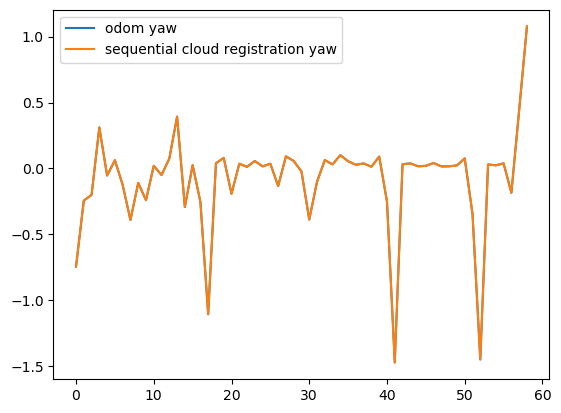

In [464]:
fig, ax = p.subplots()   
odom_euls = np.zeros([0,3])
for i in range(1,len(odom_raw)):
    rotm = R.from_quat(odom_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    odom_euls = np.append(odom_euls, rpy[None,:], axis = 0)

sr_euls = np.zeros([0,3])
for i in range(1,len(sr_raw)):
    rotm = R.from_quat(sr_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    sr_euls = np.append(sr_euls, rpy[None,:], axis = 0)

ax.plot(odom_euls[:,2], label = 'odom yaw')
ax.plot(sr_euls[:,2], label = 'sequential cloud registration yaw')
ax.legend(loc='best')

[[ 0.172376   -1.46766    -0.582194  ]
 [ 2.68904    -0.0531344  -0.571571  ]
 [ 0.743051   -0.200236    0.00346394]
 [ 0.616365   -0.0689547   0.0125885 ]
 [ 1.103      -0.0931867  -0.087286  ]
 [ 1.71506    -0.286836   -0.110594  ]
 [ 0.81117    -0.0593494  -0.117277  ]
 [ 0.753047   -0.247138    0.151088  ]
 [ 0.731152   -0.206211    0.0249515 ]
 [ 0.914868    0.0431576  -0.256375  ]]


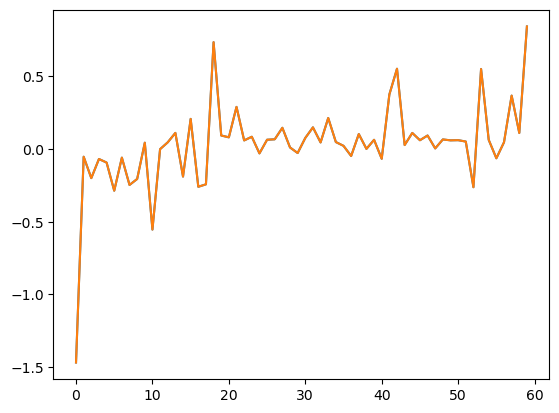

In [465]:
fig, ax = p.subplots()
print(sr_raw[:10,2:5])
ax.plot(odom_raw[:,3])
ax.plot(sr_raw[:,3])

# Draw point clouds registered according to odom

In [483]:
#load keyframe point clouds
idx = 33
fn1 = "keyframe_" + str(idx) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
idx2 = idx + 1
fn2 = "keyframe_" + str(idx2) + ".csv"
pc2 = np.loadtxt(fn2, delimiter=",")
# print(odom_raw[idx,2:5], R.from_quat(odom_raw[idx,5:]).as_euler('xyz'))
print(odom_raw[idx])

#get row corresponding to correct odometry constraint
odom_idx = np.where(odom_raw[:,0] == idx)[0][0]
print(odom_idx)
print(sr_euls[-5:])

# print(sr_raw[idx])
# print(odom_raw[idx])

[ 3.40000e+01  3.50000e+01  6.29250e-01  2.13084e-01  1.90906e-02
 -2.22432e-02  7.80593e-03  3.17102e-02  9.99219e-01]
32
[[-0.00485441 -0.0113468   0.02354324]
 [-0.0016049  -0.00885819  0.03825721]
 [-0.00544254  0.06352056 -0.1846606 ]
 [-0.05717591 -0.03667514  0.44150075]
 [ 0.206012    0.10309132  1.07683335]]


In [484]:
plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))

#draw pc2 in pc1 frame 
# p2_p1f = np.append(pc2, np.ones([len(pc2),1]), axis = 1)
# p2_p1f = p2_p1f @ np.linalg.pinv(odom[idx]) @ odom[idx+1] #had this -- not quite right??
# p2_p1f = p2_p1f[:,:3]

# p2_p1f = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_dcm()#works for odom output
p2_p1f = (pc2 + odom_raw[odom_idx,2:5]) @ (R.from_quat(odom_raw[odom_idx,5:]).as_dcm()).T #works for LC output

disp.append(Points(p2_p1f, c = 'green', r = 3, alpha = 0.5))

plt.show(disp, "scan 1 (red), scan2 (blue), scan2 in s1 frame (green)")

# DEBUG: Use (python) ICET to register keyframes

In [7]:
from ICET_spherical import ICET
from utils import R_tf
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import tensorflow as tf
%load_ext autoreload

2025-02-12 20:23:25.037577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 20:23:25.546941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2025-02-12 20:23:25.547022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2025-02-12 20:23:25.547027: W tensorflow/compiler/tf2tensorrt/utils/

In [445]:
fidelity = 50                                           # number of azimuthal bins to make square cross-section voxels 
num_iterations = 5                                      # number of iterations to run algorithm
is_draw = True                                          # visualize simulation
initial_guess = tf.constant([0., 0., 0., 0., 0., 0.])   # initial guess for transform between clouds
is_remove_moving = True                                 # remove moving objects from the frame 
is_DNN = False                                          # suppress voxels with high perspective shift using DNN

it = ICET(cloud1 = pc1, cloud2 = p2_p1f, fid = fidelity, niter = num_iterations, 
           draw = is_draw, RM = is_remove_moving, DNN_filter = is_DNN, x0 = initial_guess)
# ViewInteractiveWidget(it.plt.window) #comment out if <is_daraw == False>

 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_sequence()
 Warning! isSequence() is deprecated. Please use is_seq